<a href="https://colab.research.google.com/github/TBSantana/capstoneProjectUB/blob/main/src/train/RNN_LSTM_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The cell bellow must be executed in order to install library used during the Hyperparameter Tuning.

In [ ]:
#!pip install scikit-optimize

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from skopt import gp_minimize

## 1. Read and split the data

This cell read the transformed full data and creates two new variables `sin_month` and `cos_month`. These variables are responsable to inform the model the cyclical nature of the month. For instance, the month 12 is not 12 times greater than the month 1, since they are just 30 days away from each other.

After that, we are splitting the data indo train and validation. The are some notes about the splitting:
+ Each input for our model must have 3 rows. Due to this, our valid dataset has a size that multiple of 3;
+ The last 3 months are dedicated to the validation;

In [ ]:
cols = ['year', 'month', 'CasosCovMes', 'CasosCovMesAnt',  'availability_30', 'availability_60']
data = pd.read_csv('listings_transformed.csv.gz', usecols=cols)

df = data.groupby(['year', 'month'], as_index=False).mean()
df = df[['year', 'CasosCovMesAnt', 'CasosCovMes', 'availability_30', 'month', 'availability_60']]

df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df = df.drop(columns=['month'])

train = df.iloc[1:25]
val = df.iloc[22:]

print('Train shape:', train.shape)
print('Val shape:', val.shape)

Train shape: (24, 7)
Val shape: (6, 7)


## 2. Data Normalization

Before starting the training, we must normalize the data because they have different ranges. After this step, all data values must lie between -1 and 1.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scalerY = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(train)
scalerY.fit(train['availability_60'].values.reshape(-1, 1));

This function was built to convert our tabular dataset into a 3-D numpy array, with the shape (steps, samples, features).

In [ ]:
def prep_seqs(df, scalerX, scalerY, l=3, h=3):
    X = []
    Y = []
    for i in range(l, df.shape[0]-h):
        f = df.iloc[i-l:i]
        y = df.iloc[i:i+h]['availability_60'] 

        X.append(scalerX.transform(f))
        Y.append(scalerY.transform(y.values.reshape(-1, 1)))

    X = np.array(X)
    Y = np.array(Y)

    X = np.swapaxes(X, 0, 1)
    
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float().squeeze()

Since we are going to execute our training in the GPU, all data (training and validation) must be in the GPU as well.

In [ ]:
X, Y = prep_seqs(train, scaler, scalerY)

xval = val.iloc[-6:-3]
Xt = scaler.transform(xval.values)
Xt = np.expand_dims(Xt, axis=1)
Xt = torch.from_numpy(Xt).float()

yval = val.iloc[-3:]['availability_60']
Yt = scalerY.transform(yval.values.reshape(-1, 1))
Yt = torch.from_numpy(Yt).float().squeeze()

X = X.cuda()
Y = Y.cuda()

Xt = Xt.cuda()

print('X shape: {} and Y shape: {}'.format(X.shape, Y.shape))
print('Xt shape: {} and Yt shape: {}'.format(Xt.shape, Yt.shape))
# X shape is (steps, samples, features)

X shape: torch.Size([3, 18, 7]) and Y shape: torch.Size([18, 3])
Xt shape: torch.Size([3, 1, 7]) and Yt shape: torch.Size([3])


## 3. Training process

We are going to use a Recurrent Neural Network (RNN) from Pytorch to train our model. The network architecture is made by one layer of Long-Short Term Memory (LSTM) and one Linear layer.

In [ ]:
class LSTMRNN(nn.Module):
    def __init__(self, hidden_size, input_size):
        super(LSTMRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, 3)
        
    def forward(self, input):
        output, _ = self.lstm(input)
        output = output[-1, :, :]
        output = self.out(output) 
        return output    

## 4. Target reconstruction

This function was created to make the inverse transformation of the normalized data. For instance, if a avaibility_60 was originally 35, it became 0.5 after normalization. Inside this function, it turn into 35 again before we compute the absolute error of the training.

In [ ]:
def evaluate_model(scaler, y, pred):

  y_real = scaler.inverse_transform(y.numpy().reshape(-1, 1))
  y_hat = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
  return y_hat, mean_absolute_error(y_real, y_hat)

## 5. Training

This function execute the training process. During our implementation, we have observed that even using seeds, our results still was changing. Due to that, we decided to train the model many times, one for each seed. Then, compute the average error of each seed. This result should be a better estimator of the final prediction error. 

In [ ]:
def train_LSTM(X, Y, Xt, Yt, hidden_size=100, learning_rate=1e-3, epochs=10, n_seeds=10):

  total_errors = np.zeros((Yt.shape[0], 1, n_seeds))

  for seed in range(n_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)

    lstm = LSTMRNN(hidden_size, X.shape[-1]).cuda()

    criterion = nn.L1Loss()
    lstm_optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

    for i in range(epochs):
        lstm.zero_grad()
        
        o = lstm(X)
        loss = criterion(o, Y)
        loss.backward()
        lstm_optimizer.step()

        p = lstm(Xt)
        p = p.detach().cpu()
    
    y_hat, error = evaluate_model(scalerY, Yt, p)
    total_errors[:, :, seed] = error

    print('Seed {} - Error: {:.3f}'.format(seed, error))

  avg_seed_error = total_errors.mean(axis=-1)

  return lstm, y_hat, avg_seed_error[0][0]

The prints below show how different our errors could be, just by chance. The final error printed in `Ensemble Average Score` is a more reliable value.

In [ ]:
%%time
lstm_model, y_hat, absolute_error = train_LSTM(X, Y, Xt, Yt)
print('\nEnsemble Avg Score = {:.3f}\n'.format(absolute_error))

Seed 0 - Error: 2.199
Seed 1 - Error: 3.522
Seed 2 - Error: 2.603
Seed 3 - Error: 2.998
Seed 4 - Error: 2.804
Seed 5 - Error: 2.416
Seed 6 - Error: 2.585
Seed 7 - Error: 3.131
Seed 8 - Error: 2.264
Seed 9 - Error: 1.950

Ensemble Avg Score = 2.647

CPU times: user 230 ms, sys: 14.6 ms, total: 244 ms
Wall time: 244 ms


## 6. Prediction

The predicted values are the months between february and april. Its important to say that there was not hyperparameter tuning for the previous model. The network has captured the downward curve, but it was not that close of the real values. 

In [ ]:
y_real = scalerY.inverse_transform(Yt.numpy().reshape(-1, 1))

ndf = pd.DataFrame({'y_real': y_real[:,0], 'y_hat': y_hat[:,0]}, index=np.arange(y_hat.shape[0]))
ndf

,y_real,y_hat
0,37.524391,34.572319
1,36.568878,34.632740
2,34.651894,33.691040


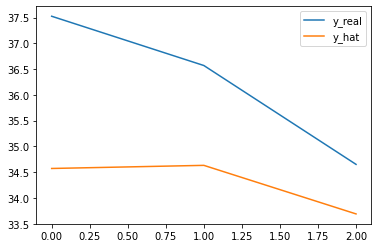

In [ ]:
ndf.plot();

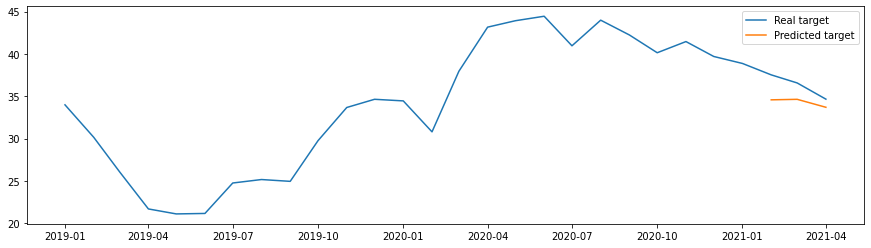

In [ ]:
df2 = data.groupby(['year', 'month'], as_index=False).mean()
df2['date'] = df2.apply(lambda x: datetime(int(x.year), int(x.month), 1), axis=1)

f, ax = plt.subplots(figsize=(15, 4))
ax.plot(df2.date.values, df2.availability_60.values, label='Real target')
ax.plot(df2.date.values[-3:], y_hat[:, 0], label='Predicted target')
ax.legend();

## 7. Hyperparameter Tuning

Now that we have a result, we are going to improve the quality of the prediction by doing hyperparameter tuning. The optimizer we are using is based in Gaussian Processs Optimization and its library is available [here](https://scikit-optimize.github.io/stable/). 

In [ ]:
%%time

def run_rnn(params):

  hidden_size, learning_rate = params

  n_seeds = 10
  total_errors = np.zeros((Yt.shape[0], 1, n_seeds))

  for seed in range(n_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)

    lstm = LSTMRNN(hidden_size, X.shape[-1]).cuda()

    criterion = nn.L1Loss()
    lstm_optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

    for i in range(10):
        lstm.zero_grad()
        
        o = lstm(X)
        loss = criterion(o, Y)
        loss.backward()
        lstm_optimizer.step()
        
        p = lstm(Xt)
        p = p.detach().cpu()
    
    y_hat, error = evaluate_model(scalerY, Yt, p)
    total_errors[:, :, seed] = error

  avg_seed_error = total_errors.mean(axis=-1)
  return avg_seed_error[0][0]  

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


The previous model was trained using the following hyperparameters:
+ hidden_size = 100
+ learning_rate = 1e-3

Now, we are going to run 50 calls to the train_LSTM_train, looking for the pair of hyperparameters that minimize the prediction error.

In [ ]:
space = [(10, 400),                       # hidden_size 
         (3e-5, 3e-1, 'log-uniform')]     # learning_rate

res = gp_minimize(run_rnn, space, random_state=0, n_calls=50)

hidden_size, learning_rate = res.x
min_avg_error = res.fun

print('Best parameters: \n\thidden_size = {}\n\tlearning_rate = {}\n\nMinimum avg error = {}'.format(hidden_size, learning_rate, min_avg_error))

Best parameters: 
	hidden_size = 260
	learning_rate = 0.0012080406410324108

Minimum avg error = 0.9306983992457389


Since we have the best pair of hyperparameters, we are going to retrain our model using all the dataset.

In [ ]:
fdf = data.groupby(['year', 'month'], as_index=False).mean()
fdf = fdf[['year', 'CasosCovMesAnt', 'CasosCovMes', 'availability_30', 'month', 'availability_60']]

fdf['sin_month'] = np.sin(2 * np.pi * fdf['month'] / 12)
fdf['cos_month'] = np.cos(2 * np.pi * fdf['month'] / 12)
fdf = fdf.drop(columns=['month'])

In [ ]:
X, Y = prep_seqs(fdf, scaler, scalerY)
X = X.cuda()
Y = Y.cuda()

print('X shape: {} and Y shape: {}'.format(X.shape, Y.shape))
# X shape is (steps, samples, features)

X shape: torch.Size([3, 22, 7]) and Y shape: torch.Size([22, 3])


After the hyperparameter tuning process, the error has decreased from **2.647** to **1.03**.


In [ ]:
%%time
best_lstm_model, new_y_hat, absolute_error = train_LSTM(X, Y, Xt, Yt, hidden_size, learning_rate)
print('\nEnsemble Avg Score = {:.5f}\n'.format(absolute_error))

Seed 0 - Error: 0.931
Seed 1 - Error: 0.540
Seed 2 - Error: 1.797
Seed 3 - Error: 1.375
Seed 4 - Error: 0.976
Seed 5 - Error: 0.958
Seed 6 - Error: 0.605
Seed 7 - Error: 0.965
Seed 8 - Error: 1.593
Seed 9 - Error: 0.620

Ensemble Avg Score = 1.03601

CPU times: user 250 ms, sys: 9.94 ms, total: 260 ms
Wall time: 257 ms


The current predicted values are closer to the real values than the previous ones.

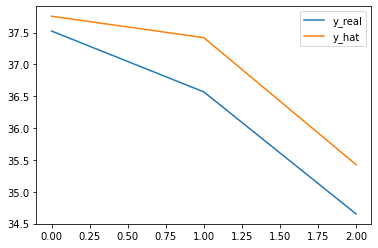

In [ ]:
ndf_tuned = pd.DataFrame({'y_real': y_real[:,0], 'y_hat': new_y_hat[:,0]}, index=np.arange(y_hat.shape[0]))
ndf_tuned.plot()

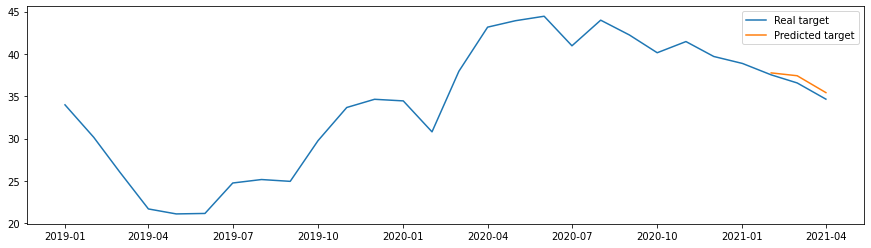

In [ ]:
df2 = data.groupby(['year', 'month'], as_index=False).mean()
df2['date'] = df2.apply(lambda x: datetime(int(x.year), int(x.month), 1), axis=1)

f, ax = plt.subplots(figsize=(15, 4))
ax.plot(df2.date.values, df.availability_60.values, label='Real target')
ax.plot(df2.date.values[-3:], new_y_hat[:, 0], label='Predicted target')
ax.legend();

## 8. Forcasting prediction

The result values from the forecasting has been shown in orange, in the chart bellow. 
+ It has a gap between the last sample of the dataset and the first predicted value. This behavior could be related to the fact that the first forecasted value is a prediction of 3 months earler. At this point, COVID-19 indicators was not that good as it are nowadays;
+ The patterns in 2019 was a strong decreasing in the listings availabiity. With the pandemic situation, the pattern at the same period of the year in 2020 was an slite increasement in the listings availability. The fact that the model was predicting a decreasement in the availability, shows that it has captured some patterns from the data.

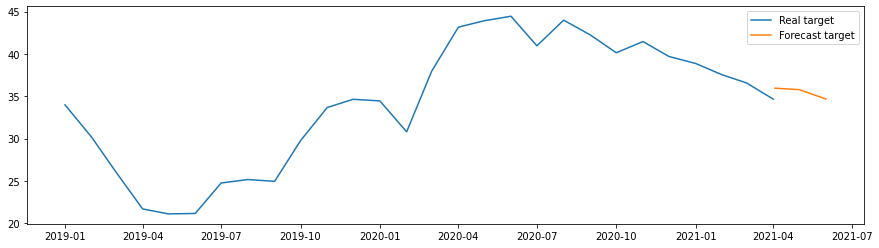

In [ ]:
xtst = val.iloc[-3:]
Xtst = scaler.transform(xtst.values)
Xtst = np.expand_dims(Xtst, axis=1)
Xtst = torch.from_numpy(Xtst).float().cuda()

pred = best_lstm_model(Xtst)
pred = pred.detach().cpu()
forecast = scalerY.inverse_transform(pred.numpy().reshape(-1, 1))

future_dates = df2.date.iloc[-3:] + timedelta(days=61)

f, ax = plt.subplots(figsize=(15, 4))
ax.plot(df2.date.values, df2.availability_60.values, label='Real target')
ax.plot(future_dates.values, forecast[:, 0], label='Forecast target')
ax.legend();